# Food Deserts in Pasadena, California

## Problem and Background

A food desert is "... an area that has limited access
to affordable and nutritious food, in contrast with an
area with higher access to supermarkets or vegetable shops
with fresh foods". [Wikipedia](https://en.wikipedia.org/wiki/Food_desert)

The city of Pasadena, California is approximately 10 miles
northeast of downtown Los Angeles, in the foothills of the
San Gabriel mountains. It has an estimated population of
141,000 people [Wikipedia](https://en.wikipedia.org/wiki/Pasadena,_California).

Pasadena has many, many restaurants. If someone was interested
in opening a restaurant in the area, I would advise them to go
elsewhere. However, there are parts of Pasadena that do not have a lot of grocery
stores, and so this report looks to see if there are any 
food deserts in Pasadena, and recommend areas where new
grocery stores could be opened.

## Data and Methodology

Several sources of data are used. First, the city of Pasadena's own
database of city borders, which is discussed in detail below.
Second, the Foursquare API will be used to find existing grocery
stores within the city's boundaries. 


## Libraries

In addition to the commonly used data science python libraries, I use
the shapely library to help get the data from Foursquare. This is documented
in greater detail further down. 

In [3]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import requests
from pandas import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from math import sqrt

# additional libraries
from shapely.geometry import shape, Point
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
address = "Pasadena, California"
geolocator = Nominatim(user_agent="Coursera_Capstone")
location = geolocator.geocode(address)
if location is not None:
    latitude = location.latitude
    longitude = location.longitude
    print("The coordinates of Pasadena are {}, {}".format(latitude, longitude))
else:
    print("Coordinates not found!")

The coordinates of Pasadena are 34.1476452, -118.1444779


## City Borders

The city of Pasadena has an open data web site [https://data.cityofpasadena.net]
which includes a downloadable GeoJSON file that defines the city's borders. 
A copy of the file that I downloaded in December of 2020 has been included in the
Github repository for this project, and the code works with a local copy.


In [5]:
map_pasadena = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(map_pasadena)
map_pasadena

## Getting Ready for Foursquare

It's tempting at this point to take the 8 zip codes that make up Pasadena, find the longitude and latitude of their centers, and query Foursqure for venues. The problem with this approach is that currently Foursquare limits API calls to 50 venues per query, and Pasadena's zip are so large that search results hit that limit. The next block of code breaks Pasadena down into a grid of much smaller 1/2 kilometer chunks, which are the starting point for getting data from Foursquare.

This required me to upgrade my Foursquare account to a "verified" account, because otherwise I would hit the 950 API call per day limit. 

I also had to limit the search to the "Food & Drink Shop" category, because otherwise I still hit the 50 venue limit. 

### GeoJSON and shapely

After doing all the work, I learned of the existance of GeoPandas, which does a better job of integrating shapely and pandas than what I've done here. That's life with python: 90% of the time someone else has already done the work for you.

Using the city's GeoJSON file, shapely library, and numpy's linspace() method, I create a grid of points that
I will use to search Foursquare. The same grid will be used later to analyze the results.

In [6]:
with open('City_Boundary.geojson') as f:
    pasadena_gj = json.load(f)

# GeoJSON files encode data longitude, latitude (rather than
# the other way around). So, to check if a point in my grid is within
# Pasadena using shapely, I have to reverse the order when
# creating the point

polygon = shape(pasadena_gj['features'][0]['geometry'])

# the purpose of this code is to create a dataframe of the 
# coordiates that make up the coordinates defined by the 
# geojson file, which I will then use to find the extreme
# edges of the city. Feels a little like overkill to use a
# dataframe to find the min and max of some values, but the
# data set is relatively small so I'm not going to worry about
# that. 

coordinates_dict = {"longitude":[], "latitude":[]}
        
for c in pasadena_gj['features'][0]['geometry']['coordinates'][0][0]:
    coordinates_dict['longitude'].append(c[0])
    coordinates_dict['latitude'].append(c[1])

coordinates_df = pd.DataFrame(coordinates_dict)

lat_min = coordinates_df['latitude'].min()
lat_max = coordinates_df['latitude'].max()

long_min = coordinates_df['longitude'].min()
long_max = coordinates_df['longitude'].max()

# The city is roughly 14.5 kilometers wide (at its widest)
# and roughly 11.3 kilometers tall (at its tallest)
# Using linspace, I  create a grid of points roughly
# 500 meters apart and then (more on this later)
# use that grid to search Foursquare

latitudes = np.linspace(lat_min, lat_max, 30)
longitudes = np.linspace(long_min, long_max, 24)


In [7]:
# quick check to verify that the grid does what I want

map_of_grid = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(map_of_grid)

number_of_points = 0

# we'll need this list later

search_points = []

for lat in latitudes:
    for long in longitudes:
        point = Point(long, lat)
        if polygon.contains(point):
            search_points.append(point)
            number_of_points += 1
            label_text = "{}, {}".format(lat, long)
            label = folium.Popup(label_text, parse_html=True)
            folium.CircleMarker(
                [lat, long],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7).add_to(map_of_grid)

print("Total Number of Points: %d" % (number_of_points))            
            
map_of_grid

Total Number of Points: 218


## Getting data from Foursquare

Finally time to actually query Foursquare. 

In [8]:
CLIENT_ID = 'ZWNOEXV5OG0240EV0Y5YERTPBTWOQRMEG2ZEV5DQR5D2IHTJ' # my Foursquare ID
CLIENT_SECRET = 'O1BJBPD2QA5QAC3VDVFBXS1J1GAGISXTY5BQKZOKAXUEPM2W' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # the maximum allowed as of this writing
RADIUS = 500 # in meters
CATEGORIES = '4bf58dd8d48988d1f9941735' # this is "Food & Drink Shop", from the API documentation

# I notice data scientists don't make a lot of use
# of object oriented programming, which I think
# is a mistake.

class Venue():
    def __init__(self, name, lat, long, category, id):
        self.name = name
        self.latitude = lat
        self.longitude = long
        self.category = category
        self.id = id
        
    def __str__(self):
        return "[{}, {}, {}, {}, {}]".format(self.name,
                                        self.category,
                                        self.id,
                                        self.latitude,
                                        self.longitude)

def get_venues(lat, long):
    venues_list = []

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        RADIUS, 
        LIMIT,
        CATEGORIES)
    results = requests.get(url).json()
    
    if (results['response']
                and results['response']['groups']
                and results['response']['groups'][0]
                and results['response']['groups'][0]['items']):
        raw_venues = results['response']['groups'][0]['items']
        if len(raw_venues) == 50:
            print("\nHIT THE LIMIT\n")
        for r in raw_venues:
            v = Venue(r['venue']['name'],
                      r['venue']['location']['lat'],
                      r['venue']['location']['lng'],
                      r['venue']['categories'][0]['name'],
                      r['venue']['id'])
            venues_list.append(v)
        
    return venues_list

In [19]:
number_of_api_calls = 0

# I use a dictionary to eliminate venues that show up 
# more than once, which is possible since each search area
# overlaps a little

my_venues = {}

#for lat in latitudes:
#    for long in longitudes:
#        point = Point(long, lat)

for point in search_points:
    lat = point.y
    long = point.x
    for v in get_venues(lat, long):
        # Any operation that takes more than 5 seconds needs
        # some kind of visual feedback to indicate that work
        # is being done, as opposed to code spinning in an
        # infinite loop
        print(".", end="")
        my_venues[v.id] = v
        number_of_api_calls += 1

print("\nUsed the API {} times".format(number_of_api_calls))

print("Loaded {} venues".format(len(my_venues)))

.....................................................................................................................................................................................................................................................................................................................................................
Used the API 341 times
Loaded 121 venues


In [12]:
# A sanity check. Even though the query was
# limited to the "Food & Drink Shop" category, while reviewing the results
# I noticed that a few restaraunts and other venues were included.
# I print out the unique values of categories, and then manually
# remove a few (i.e. "Sushi Restaurant").

traverse = []

for v in my_venues.values():
    if v.category not in traverse:
        traverse.append(v.category)
        
print(traverse)
print(len(traverse))

['American Restaurant', 'Liquor Store', 'Grocery Store', 'Deli / Bodega', 'Food & Drink Shop', 'Wine Shop', 'Gourmet Shop', 'Health Food Store', 'Food Service', 'Kitchen Supply Store', 'Farmers Market', 'Supermarket', 'Coffee Shop', 'Juice Bar', 'Wine Bar', 'Sushi Restaurant', 'Seafood Restaurant', 'Bakery', 'Supplement Shop', 'Café', 'Gift Shop', 'Pizza Place', 'Tea Room', 'Fast Food Restaurant', 'Big Box Store', 'Furniture / Home Store', 'Butcher', 'Fish Market', 'Restaurant', 'Organic Grocery']
30


In [20]:
# this venue has been closed for many years, so it is removed.
if '4b68bf44f964a520968a2be3' in my_venues.keys():
    my_venues.pop('4b68bf44f964a520968a2be3')

# Map the search results. We will skip anything that isn't 
# actually a grocery store.

food_stores = ['Liquor Store', 'Grocery Store', 'Deli / Bodega', 
               'Food & Drink Shop', 'Wine Shop', 'Gourmet Shop', 
               'Health Food Store', 'Supermarket', 
               'Big Box Store', 'Butcher', 'Fish Market', 
               'Organic Grocery']

colors = ['red', 'blue', 'green', 
          'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 
          'darkgreen', 'cadetblue', 'darkpurple',
          'pink']

color_map = dict(zip(food_stores, colors))

groceries_map = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(groceries_map)

# We double check that all venues are in Pasadena, and filter out the 
# venues in categories we don't want.

for v in my_venues.values():
    point = Point(v.longitude, v.latitude)
    if polygon.contains(point) and v.category in food_stores:
        label_text = "{} ({}) ({})".format(v.name, v.category, v.id)
        label = folium.Popup(label_text, parse_html=True)
        folium.CircleMarker(
            [v.latitude, v.longitude],
            radius=5,
            popup=label,
            color=color_map[v.category],
            fill=True,
            fill_color=color_map[v.category],
            fill_opacity=0.7).add_to(groceries_map)
       
groceries_map

## Initial Analysis

There are a couple of data cleaning points worth noting here. First, the area at the west
side of the city includes a large park and sports arena. The lack of venues 
is not surprising. 

In the  map above, there are clearly parts of the city that do not
have any kind of grocery stores. It would be nice if we could quantify
that, so we're going to start by doing some scoring. First, for each point
in the search grid, we're going to find the closest store, and then do a 
histogram just to get an insight into the data.

In [21]:
# A simple Euclidean distance is sufficient for our
# purposes. Strictly speaking this isn't perfect
# because of the curvature of the Earth, but for
# the small distances involved that shouldn't be a proble.
# def calculate_distance(search_point, venue):
#     # remember, in a point the value of x is the longitude
#     # and the value of y is the latitude
#     d = search_point.distance(Point(venue.longitude, venue.latitude))
#   return d

# Shapely has a distance() function that would work nicely for
# our purposes, if longitude and latitude formed a perfect grid.
# But they do not: 1 degree of latitude is roughly 88 kilometers
# at Pasadena, while 1 degree of longitude is 110.5 kilometers.
# Which means to get the distance between a grocery store a 
# point in the search grid, I first need to convert degrees
# to kilometers
from math import sqrt

def calculate_distance(search_point, venue):
    deg_latitude = search_point.y - venue.latitude
    deg_longitude = search_point.x - venue.longitude
    km_latitude = deg_latitude * 88
    km_longitude = deg_longitude * 110.5
    distance = sqrt(km_latitude**2 + km_longitude**2)
    return distance

In [22]:
closest = []
for s in search_points:
    distances = [calculate_distance(s, my_venues[k]) for k in my_venues.keys()]
    closest.append(min(distances))

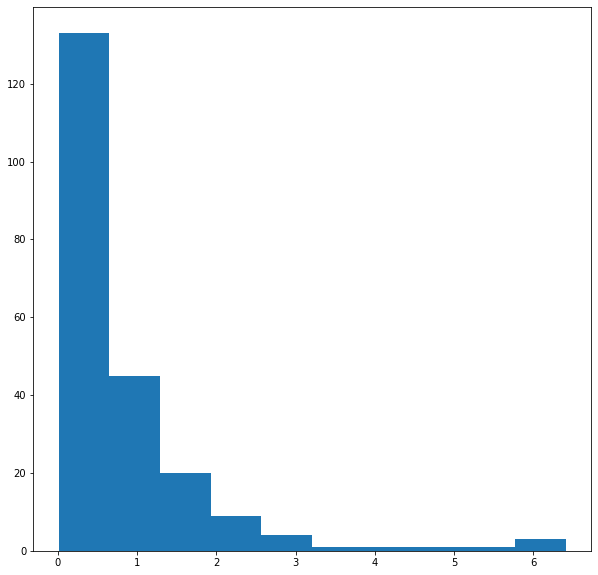

In [23]:
# A quick histogram suggests we're on the 
# right track - most of the city has adequate access
# to fresh food, but we will dive deeper

fig = plt.figure(figsize=(10, 10))
xticks = np.linspace(0, 11, 8, endpoint=True)
ax = fig.add_subplot(1, 1, 1)
ax.hist(closest, bins=10)
plt.show()

In [24]:
# sklearn kmeans only works with two dimensional
# arrays. I only have one feature, so I use reshape
# to make it into a 2d array

np_closest = np.array(closest)
k_means = KMeans(init="k-means++", n_clusters=7, n_init=12)
k_means.fit(np_closest.reshape(-1, 1))
k_means_labels = k_means.labels_
print(k_means_labels)

[5 5 5 6 1 4 4 5 5 5 5 5 5 1 4 4 1 1 1 1 1 1 1 1 4 4 1 4 4 5 5 5 4 4 4 4 1
 4 4 1 4 4 1 1 1 1 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1 1 1 1 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 4 4 4 4 4 4 4 4 1 4 1 4 4 1 4 4 4 6 6 5 4 4 4 4 4
 4 4 1 1 4 1 1 4 1 1 4 1 6 6 5 1 1 4 4 4 4 4 1 1 1 5 1 4 1 5 1 5 2 2 6 5 4
 4 4 1 1 4 4 4 4 4 1 5 1 1 5 5 6 2 2 6 5 4 4 4 1 1 4 4 4 4 5 6 2 2 6 5 1 4
 1 4 1 4 4 5 6 6 6 5 1 4 1 4 4 6 6 6 6 6 6 6 6 2 2 2 0 0 3 3 3 3 3]


In [25]:
# quick sanity check to make sure all the values are lining up

print(len(k_means_labels))
print(len(search_points))
print(k_means_labels[0])
print(search_points[0])

218
218
5
POINT (-118.1406696371739 34.12178891531039)


In [27]:
# that looks good. Now let's re-draw the map of the grid
# using the labels to color code the search points

k_means_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(k_means_map)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
          'gray', 'black', 'lightgray']

# this was the result of A LOT of experimentation
# colors = ['#0040ff', '#00061a', '#809fff', '#99b3ff', '#002080']


# colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred']

# order: 1, 4, 5, 2, 3, 6, 0

# colors = ['#e6ecff', '#0061a', '#0040ff', '#4d79ff', '#002db3', '#002080', '#99b3ff']

for i in range(0, len(search_points)):
    color = colors[k_means_labels[i]]
    label_text = str(k_means_labels[i])
    folium.CircleMarker(
        [search_points[i].y, search_points[i].x],
        radius=5,
        popup=label_text,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(k_means_map)
            
k_means_map

## Analysis

The core of the city of Pasadena has adequate access to fresh food
available at grocery stores. However, there are significant 
segments of the city that do not. 

Most of the western part of the city does not have close access
to a grocery store. However, these areas would not be good places
to open a store, as they are dominated by nature parks or the
residents are fairly wealthy and unintersted in having any kind
of commercial development.

The area in the north east corner of the city is under
served. If the Albertsons were still open, this would cover most
of this region, but its closure has left an impact. 
I also think the border neighborhoods (coded in light blue)
would benefit from closer access to non-restaurant food options.